# Weekly Tutorial Problems: Week 2
Jacob Sanz-Robinson, Meenakshi Khosla, Eric Bridgeford

Welcome to the second set of tutorial problems of the ABCD ReproNim Machine Learning course!

Let's get started. If you aren't familiar with any of the modules we are importing for a problem, try skimming through the module documentation for hints and examples.

# Lecture 1: Supervised Machine Learning

### Problem 1: Linear SVM

We have loaded up sklearn's Iris dataset (as well as a few other sklearn modules) and wish to use a model to classify it's 3 species of flowers.

**Your task:**

* Using sklearn, create a pipeline that uses the StandardScaler to remove the mean and scale the data to unit variance, and then uses the LinearSVC to implement an SVM. The SVM should have hyperparameters: C=10, and hinge loss function. Fit the pipeline to the data, and cross-validate it.
* If you wanted a non-linear kernel, you would use the "sklearn.svm.SVC" module instead. Have a brief glance at it's documentation and the different types of kernels you can specify as parameters (it's good to know these exist!). Optionally, implement a "sklearn.svm.SVC" model for the problem.

In [45]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"].astype(np.float64) #3 classes of flowers.

model = Pipeline([('scaler', StandardScaler()),
                  ('linear_svc', LinearSVC(C=10, loss='hinge', max_iter=1e5))])
model.fit(X, y)
cv_results = cross_validate(model, X, y)
print(cv_results['test_score'])

[0.96666667 1.         0.93333333 0.9        0.93333333]


### Problem 2: Tree-based model and ensembles: California housing dataset regression


We are going to be using our new ML knowledge to try and estimate median house values in Californian housing districts using some tree-based models. The [sklearn dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) we will use  was derived from the 1990 U.S. census. The prices are in hundreds of thousands of dollars ($100,000).

Firstly, we need to import the libraries we will be using, and download the data. If you don't recognize a module we are importing, I suggest you have a quick glance at it's documentation page!

In [72]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import pandas as pd

chd = datasets.fetch_california_housing()
X, y = chd["data"], chd["target"]

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("\n Data X")
print(X)
print("\n Target y:")
print(y)

X shape:  (20640, 8)
y shape:  (20640,)

 Data X
[[   8.3252       41.            6.98412698 ...    2.55555556
    37.88       -122.23      ]
 [   8.3014       21.            6.23813708 ...    2.10984183
    37.86       -122.22      ]
 [   7.2574       52.            8.28813559 ...    2.80225989
    37.85       -122.24      ]
 ...
 [   1.7          17.            5.20554273 ...    2.3256351
    39.43       -121.22      ]
 [   1.8672       18.            5.32951289 ...    2.12320917
    39.43       -121.32      ]
 [   2.3886       16.            5.25471698 ...    2.61698113
    39.37       -121.24      ]]

 Target y:
[4.526 3.585 3.521 ... 0.923 0.847 0.894]


**Your task:**
* Build a DecisionTreeRegressor and a RandomForestRegressor and cross-validate each of them on the housing data. Start by using a maximum depth of 3 for both trees, and 10 estimators for the Random Forest.
* Try a few different settings for the parameters (or do a grid search). Report the parameters that led to the best scores.
* Use VotingRegressor to make an ensemble that averages the output of the two tree models. Try to make the ensemble outperform all of the base models. If necessary add more models of your choice to the ensemble.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV

In [36]:
decision_tree = GridSearchCV(DecisionTreeRegressor(),
                             {'max_depth': np.arange(3, 10)})
decision_tree_results = cross_validate(decision_tree, X, y,
                                       return_estimator=True)
for i in range(len(decision_tree_results['test_score'])):
    print(decision_tree_results['estimator'][i].best_params_,
          decision_tree_results['test_score'][i])

{'max_depth': 5} 0.32603462752873646
{'max_depth': 5} 0.5249918171423982
{'max_depth': 7} 0.6098468627378414
{'max_depth': 7} 0.4311073071346555
{'max_depth': 6} 0.5738503197094041


In [40]:
random_forest = GridSearchCV(RandomForestRegressor(),
                             {'max_depth': np.arange(3, 10),
                              'n_estimators': np.arange(10, 100, 20)},
                             n_jobs=-1)
random_forest_results = cross_validate(random_forest, X, y,
                                       return_estimator=True,
                                       n_jobs=-1)
for i in range(len(random_forest_results['test_score'])):
    print(random_forest_results['estimator'][i].best_params_,
          random_forest_results['test_score'][i])

{'max_depth': 9, 'n_estimators': 90} 0.5207287281092696
{'max_depth': 9, 'n_estimators': 70} 0.6680696538157294
{'max_depth': 9, 'n_estimators': 90} 0.7181450742477604
{'max_depth': 9, 'n_estimators': 90} 0.562573610099891
{'max_depth': 9, 'n_estimators': 50} 0.6626153064655347


In [62]:
decision_tree_best = DecisionTreeRegressor(max_depth=7)
random_forest_best = RandomForestRegressor(max_depth=9, n_estimators=90)
elasticnet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                          n_jobs=-1)
ensemble = VotingRegressor([('decision_tree', decision_tree_best),
                            ('random_forest', random_forest_best),
                            ('elasticnet', elasticnet)])
ensemble_results = cross_validate(ensemble, X, y, n_jobs=-1)
print(ensemble_results['test_score'])

[0.55618129 0.6046626  0.67871015 0.55975002 0.68932062]


In [68]:
print(f"decision tree: {decision_tree_results['test_score'].mean():.3f}")
print(f"random forest: {random_forest_results['test_score'].mean():.3f}")
print(f"ensemble     : {ensemble_results['test_score'].mean():.3f}")

decision tree: 0.493
random forest: 0.626
ensemble     : 0.618


### Problem 3: Wine Classification

Since I figure it's a good assumption that most of the students reading this [enjoy some wine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6072905/) from time to time, this problem is about classifying different kinds of the classic fermented grape beverage. Any typos found in this question are purely incidental. 

I based this question on one of [Microsoft's Documentation ML Basics GitHub repo](https://github.com/MicrosoftDocs/ml-basics)'s challenges, and I highly suggest you check out their repository if you want more ML problems with solutions when you finish this notebook!

We import the dataset and inspect it's contents.

In [78]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

wine = load_wine(as_frame=True)
X, y = wine['data'].values, wine['target'].values

#See features for 10 random wines
data = pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])
data.sample(10)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
101,12.60,1.34,1.90,18.5,88.0,1.45,1.36,0.29,1.35,2.450000,1.04,2.77,562.0,1.0
113,11.41,0.74,2.50,21.0,88.0,2.48,2.01,0.42,1.44,3.080000,1.10,2.31,434.0,1.0
79,12.70,3.87,2.40,23.0,101.0,2.83,2.55,0.43,1.95,2.570000,1.19,3.13,463.0,1.0
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.350000,1.31,3.50,985.0,1.0
143,13.62,4.95,2.35,20.0,92.0,2.00,0.80,0.47,1.02,4.400000,0.91,2.05,550.0,2.0
97,12.29,1.41,1.98,16.0,85.0,2.55,2.50,0.29,1.77,2.900000,1.23,2.74,428.0,1.0
128,12.37,1.63,2.30,24.5,88.0,2.22,2.45,0.40,1.90,2.120000,0.89,2.78,342.0,1.0
74,11.96,1.09,2.30,21.0,101.0,3.38,2.14,0.13,1.65,3.210000,0.99,3.13,886.0,1.0
171,12.77,2.39,2.28,19.5,86.0,1.39,0.51,0.48,0.64,9.899999,0.57,1.63,470.0,2.0
93,12.29,2.83,2.22,18.0,88.0,2.45,2.25,0.25,1.99,2.150000,1.15,3.30,290.0,1.0


In [79]:
#See dimensions
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))

#See features and labels for first 4 wines
for n in range(0, 4):
    print("Wine", str(n+1), "\n  Features:",list(X[n]), "\n  Label:", y[n])

X shape: (178, 13)
y shape: (178,)
Wine 1 
  Features: [14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0] 
  Label: 0
Wine 2 
  Features: [13.2, 1.78, 2.14, 11.2, 100.0, 2.65, 2.76, 0.26, 1.28, 4.38, 1.05, 3.4, 1050.0] 
  Label: 0
Wine 3 
  Features: [13.16, 2.36, 2.67, 18.6, 101.0, 2.8, 3.24, 0.3, 2.81, 5.68, 1.03, 3.17, 1185.0] 
  Label: 0
Wine 4 
  Features: [14.37, 1.95, 2.5, 16.8, 113.0, 3.85, 3.49, 0.24, 2.18, 7.8, 0.86, 3.45, 1480.0] 
  Label: 0


**Your task:**

* Write a wine classifier and cross-validate it! Try to obtain upwards of 80% accuracy. Get creative and use any supervised learning model from the lecture, and any preprocessing steps you fancy!

In [80]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier

In [84]:
random_forest = GridSearchCV(RandomForestClassifier(),
                             {'max_depth': np.arange(3, 6),
                              'n_estimators': np.arange(3, 6)},
                             n_jobs=-1)
random_forest_results = cross_validate(random_forest, X, y,
                                       return_estimator=True,
                                       n_jobs=-1)
for i in range(len(random_forest_results['test_score'])):
    print(random_forest_results['estimator'][i].best_params_,
          random_forest_results['test_score'][i])

{'max_depth': 3, 'n_estimators': 3} 0.8333333333333334
{'max_depth': 5, 'n_estimators': 5} 0.8611111111111112
{'max_depth': 5, 'n_estimators': 5} 0.9444444444444444
{'max_depth': 4, 'n_estimators': 5} 0.9428571428571428
{'max_depth': 4, 'n_estimators': 4} 0.9714285714285714


**Your task:**

* Use the VotingClassifier module to make a classification ensemble that uses hard voting. Add at least two more models to the ensemble alongside the one from the last task, and try to obtain a higher score in your cross-validation than you initially did with a single model.

In [85]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [88]:
random_forest_best = RandomForestClassifier(max_depth=5, n_estimators=5)
logistic = LogisticRegression(max_iter=1e5)
naive_bayes = GaussianNB()

ensemble = VotingClassifier([('random_forest', random_forest_best),
                             ('logistic', logistic),
                             ('naive_bayes', naive_bayes)])
ensemble_results = cross_validate(ensemble, X, y, n_jobs=-1)
print(ensemble_results['test_score'])

[0.97222222 0.94444444 0.97222222 0.97142857 1.        ]


In [89]:
print(f"random forest: {random_forest_results['test_score'].mean():.3f}")
print(f"ensemble     : {ensemble_results['test_score'].mean():.3f}")

random forest: 0.911
ensemble     : 0.972


# Lesson 2: Unsupervised Machine Learning

### Problem 1: K-means Clustering

In this question we are going to have a look at K-Means clustering. Firstly we generate two sets of 2D data. We generate isotropic Gaussian blobs using make_blobs, and interleaving half circles using make_moons.

**Your task:**

* Build and fit a k-means models for each of the two datasets we synthesized. Use 3 clusters for the blobs, and 2 for the moons.
* Obtain the cluster labels or predictions for each of the datasets, and plot them (preferably each cluster should correspond to a different colour or marker).
* On which of the datasets does K-means clustering perform better? Why could this be the case?
  > K-means seems perfect for blobs but not (half) moons.  
  > This is because K-means relies on *inertia* or within-cluster variance from centroids. Inertia assumes convex (circular) and isotropic (symmetric) clusters. The moons break both.
* Read the [sklearn documentation for K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Be aware that parameters like n_init, and max_iter exist.

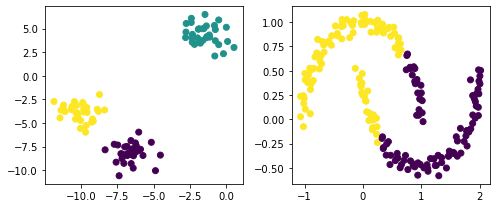

In [15]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X, y = make_blobs(random_state=1)
X_2, y_2 = make_moons(n_samples=200, noise=0.05, random_state=0)

kmeans = KMeans(3)
kmeans.fit(X)
kmeans_2 = KMeans(2)
kmeans_2.fit(X_2)

fig, axs = plt.subplots(1, 2, figsize=(7,3))
axs[0].scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
axs[1].scatter(X_2[:, 0], X_2[:, 1], c=kmeans_2.labels_)
plt.tight_layout()
plt.show()

The next part is more of an example for your learning than a problem for you to solve.
What if we had a dataset where we didn't know how many clusters we wanted? Let's turn out attention back to the blobs. We would use the elbow method, as follows. We run the clustering for a range of clusters k (we are using 1 to 10 for this example) and for each value, we calculate the sum of squared distances from each point to its assigned center, known as distortions. When the distortions are plotted against k, we look for the k where the line looks like a sharp “elbow” (the point of inflection on the curve). This will be our best value of k.

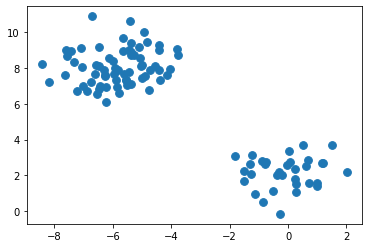

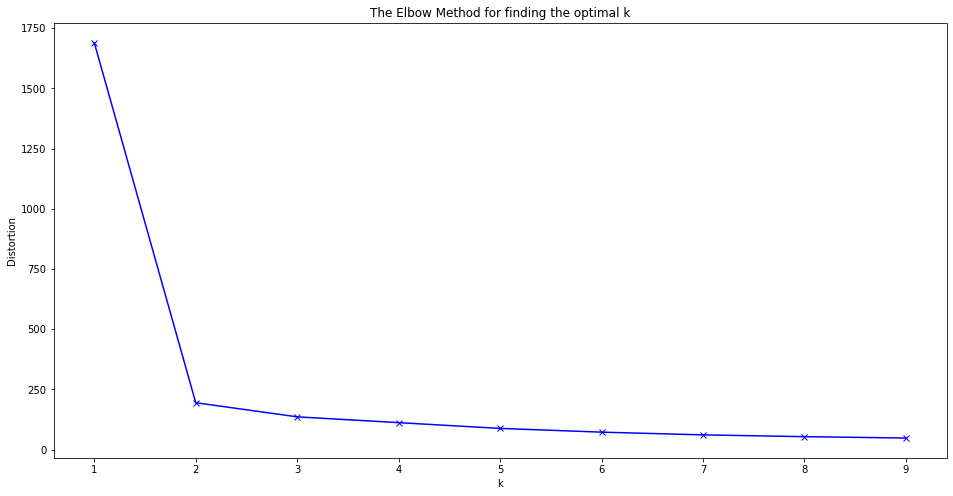

In [16]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X, y = make_blobs(random_state=5)
plt.scatter(X[:, 0], X[:, 1], s=60)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

#Plotting the distortions of K-Means
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for finding the optimal k')
plt.show()

### Problem 2: Gaussian Mixture Models, Generating Data, and Embeddings

We start off with a similar setup to our 2-moons dataset task in the previous problem.

**Your task:**
* Create a GaussianMixture model with 2 components and choose the adequate parameter to ensure each component has its own general covariance matrix (see the documentation for the parameter you need).
* Fit the model to the data and predict the classes of the moon data points. Plot your predictions, did you notice any improvements over k-means?
  > Not much improvement... Gaussian mixture models generalizes K-means to include information about covariances. They still assume convex clusters.

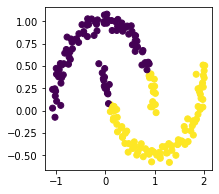

In [27]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
labels = gmm.predict(X)

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

At this point some of you will be wondering "So...How can we succesfully separate the two strips of the two moons dataset?". One technique that is often attempted for such tasks are the Spectral Embeddings we saw in class.

**Your task:**
* Recreate your GMM clustering solution in the past task of the question. However, before the GMM model, use a SpectralEmbedding with 2 components to transform the data. Feed this transformed version of the data to the GMM and plot the GMM's predictions. How does it perform now?
  > Clusters are nearly perfect. Spectral embedding represents the data as a graph and finds optimal cuts. The new dimension neatly separates the two moons.

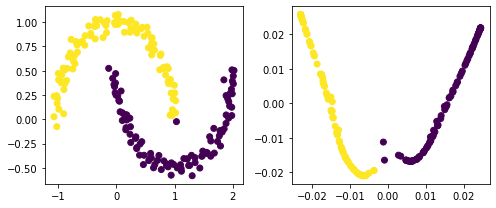

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons
from sklearn.manifold import SpectralEmbedding
from sklearn.pipeline import make_pipeline

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

embedding = SpectralEmbedding(2)
X_transformed = embedding.fit_transform(X)
gmm = GaussianMixture(2)
gmm.fit(X_transformed)
labels = gmm.predict(X_transformed)

fig, ax = plt.subplots(1, 2, figsize=(7,3))
ax[0].scatter(X[:, 0], X[:, 1], c=labels)
ax[1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels)
plt.tight_layout()
plt.show()

What are the added bonuses of using a GMM, then? While they do often perform better on more complex-shaped clustering situations than k-means, GMMs are technically not clustering models, but rather probability-based density estimation models. They have the ability to describe the way in which data is distributed, and generate it.

**Your task:**
* Say you want to model the dataset distribution and generate your own moon shapes similar to the data we fitted.
* Firstly, Create another GMM and fit it to the data, this time make it have 16 components. Using 16 Gaussians allows us to model the overall distribution of the input data, rather than finding clusters.
* Secondly, Use the 'sample' method from the GMM to generate 200 data points.
* Plot these points, what do they look like?

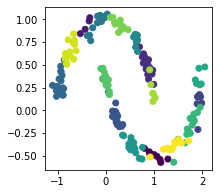

In [38]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

gmm = GaussianMixture(16)
gmm.fit(X)

X_sample, labels = gmm.sample(200)
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(X_sample[:, 0], X_sample[:, 1], c=labels)
plt.show()

# Problem 3: Applying these concepts to Neuroscience

This final problem has the goal of showing you how the discussed unsupervised learning techniques can be applied to real neuroimaging data. We have provided a MatLab (.mat) file containing a single diffusion connectome (in a few different atlases) acquired using a parcellation that has hemispheric separation of nodes.
[This paper](https://www.pnas.org/content/116/13/5995) found that  left/right hemisphere community separation can be achieved with unsupervised learning methods. We will implement a simplified version of this pipeline.

**Your task:**
* Use a Spectral Embedding to transform the connectivity data. Use 2 components for visualization purposes.
* Using a relevant unsupervised learning technique from the lecture, perform clustering on the transformed data. Make a plot to visualize your model's predictions.
* OPTIONAL: If anybody wants to read the paper and try implementing more of their details into your code and see how it affects the results...We'd be curious to hear how it went!

It *should* split by hemisphere, but due to the simplifications it could instead split functionally (i.e. Yeo groups) depending on how coarse the parameters want the clusters to be.

In [39]:
import scipy.io
import numpy as np

#Read in the connectome MAT file
mat = scipy.io.loadmat('acq-64dir_space-T1w_desc-preproc_space-T1w_msmtconnectome.mat')

#Obtain the streamline count weighted by both SIFT and inverse node volumes
#Using AAL coz it is anatomically defined, as opposed to functionally defined like most other atlases in the file.
connectivity = mat["aal116_sift_invnodevol_radius2_count_connectivity"]

con = np.asarray(connectivity)
print(con.shape)

# Your code here

(116, 116)


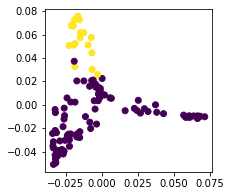

In [54]:
embedding = SpectralEmbedding(2)
transformed = embedding.fit_transform(con)
gmm = GaussianMixture(2)
gmm.fit(con)
labels = gmm.predict(con)

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(transformed[:, 0], transformed[:, 1], c=labels)
plt.show()